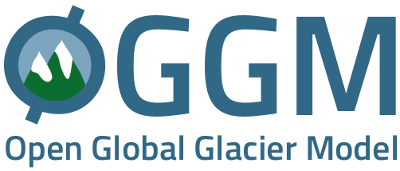

# Processing WGMS mass-balance data for OGGM

In this notebook, we use the most recent lookup table provided by the WGMS to prepare the reference mass-balance data for the OGGM model.

For this to work you'll need the latest lookup table (available through official channels soon), the latest WGMS FoG data (available [here](http://wgms.ch/data_databaseversions/)), and the latest RGI version (available [here](http://www.glims.org/RGI/)).

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Read the WGMS files

In [ ]:
idir = '/home/mowglie/Downloads/Links/'
df_links = pd.read_csv(os.path.join(idir, 'WGMS_FoG_GLACIER_ID_LUT_v2017-01-13.csv'), encoding='iso8859_15')
df_mb_all = pd.read_csv(os.path.join(idir, 'WGMS-FoG-2016-08-EE-MASS-BALANCE.csv'), encoding='iso8859_15')

In [ ]:
'Total number of links: {}'.format(len(df_links))

In [ ]:
df_links = df_links.dropna(subset=['RGI_ID'])  # keep the ones with a valid RGI ID
'Total number of RGI links: {}'.format(len(df_links))

## Select WGMS IDs with more than N years of mass-balance 

In [ ]:
df_mb = df_mb_all[df_mb_all.LOWER_BOUND.isin([9999])].copy()  # remove the profiles
gp_id = df_mb.groupby('WGMS_ID')
ids_5 = []
ids_1 = []
for wgmsid, group in gp_id:
    if np.sum(np.isfinite(group.ANNUAL_BALANCE.values)) >= 5:
        ids_5.append(wgmsid)
    if np.sum(np.isfinite(group.ANNUAL_BALANCE.values)) >= 1:
        ids_1.append(wgmsid)

In [ ]:
print('Number of glaciers with more than 1 MB years: {}'.format(len(ids_1)))
print('Number of glaciers with more than 5 MB years: {}'.format(len(ids_5)))

## Number of glaciers in the lookup table with at least 5 years of valid MB data

In [ ]:
'Number of matches in the WGMS lookup-table: {}'.format(len(df_links.loc[df_links.WGMS_ID.isin(ids_5)]))

In [ ]:
# keep those
df_links_sel = df_links.loc[df_links.WGMS_ID.isin(ids_5)]

## Duplicates?

Yes:

In [ ]:
df_links_sel.loc[df_links_sel.duplicated('RGI_ID', keep=False)]

Careser is an Italian glacier which is now disintegrated in smaller parts. Here a screenshot from the WGMS exploration tool:

<img src="https://www.dropbox.com/s/a0eoq6rrhimrolu/wgms_1.jpg?dl=1" width="80%">

We keep the oldest MB series and discard the newer ones which are for the smaller glaciers (not represented in RGI).

In [ ]:
# We keep CARESER as this is the longest before they split
df_links_sel = df_links_sel.loc[~ df_links_sel.WGMS_ID.isin([3346, 3345])]

The two norwegian glaciers are part of an ice cap:

<img src="https://www.dropbox.com/s/q6nh7qef4mrf1hz/wgms_2.jpg?dl=1" width="80%">

The two mass-balance time series are very close to each other, unsurprisingly:

In [ ]:
df_mb.loc[df_mb.WGMS_ID.isin([3339])].set_index('YEAR').ANNUAL_BALANCE.plot()
df_mb.loc[df_mb.WGMS_ID.isin([3343])].set_index('YEAR').ANNUAL_BALANCE.plot();

Since there is no reason for picking one series over the other, we have to remove both from the list.

In [ ]:
# The two nowegians glaciers are some part of an ice cap. I'll just remove them both
df_links_sel = df_links_sel.loc[~ df_links_sel.WGMS_ID.isin([3339, 3343])]

In [ ]:
'Final number of matches in the WGMS lookup-table: {}'.format(len(df_links_sel))

In [ ]:
# add some simple stats
df_links_sel['RGI_REG'] = [rid.split('-')[1].split('.')[0] for rid in df_links_sel.RGI_ID]
df_links_sel['N_MB_YRS'] = [len(df_mb.loc[df_mb.WGMS_ID == wid]) for wid in df_links_sel.WGMS_ID]

## Write out the mass-balance data

In [ ]:
odir = '/home/mowglie/Downloads/WGMS'

### Annual MB

In [ ]:
for rid, wid in zip(df_links_sel.RGI_ID, df_links_sel.WGMS_ID):
    df_mb_sel = df_mb.loc[df_mb.WGMS_ID == wid].copy()
    df_mb_sel = df_mb_sel[['YEAR', 'WGMS_ID', 'POLITICAL_UNIT', 'NAME', 'AREA', 'WINTER_BALANCE', 
                           'SUMMER_BALANCE',  'ANNUAL_BALANCE', 'REMARKS']].set_index('YEAR')
    df_mb_sel['RGI_ID'] = rid
    df_mb_sel.to_csv(os.path.join(odir, 'mbdata', 'mbdata_WGMS-{:05d}.csv'.format(wid)))

### Profiles

In [ ]:
for rid, wid in zip(df_links_sel.RGI_ID, df_links_sel.WGMS_ID):
    df_mb_sel = df_mb_all.loc[df_mb_all.WGMS_ID == wid].copy()
    df_mb_sel = df_mb_sel.loc[df_mb_sel.LOWER_BOUND != 9999]
    df_mb_sel = df_mb_sel.loc[df_mb_sel.UPPER_BOUND != 9999]
    if len(df_mb_sel) == 0:
        df_links_sel.loc[df_links_sel.RGI_ID == rid, 'HAS_PROFILE'] = False
        continue
    lb = set()
    for yr in df_mb_sel.YEAR.unique():
        df_mb_sel_yr = df_mb_sel.loc[df_mb_sel.YEAR == yr]
        mids = df_mb_sel_yr.LOWER_BOUND.values*1.
        mids += df_mb_sel_yr.UPPER_BOUND.values[:len(mids)]
        mids *= 0.5
        [lb.add(int(m)) for m in mids]
    prof = pd.DataFrame(columns=sorted(list(lb)), index=sorted(df_mb_sel.YEAR.unique()))
    for yr in df_mb_sel.YEAR.unique():
        df_mb_sel_yr = df_mb_sel.loc[df_mb_sel.YEAR == yr]
        mids = df_mb_sel_yr.LOWER_BOUND.values*1.
        mids += df_mb_sel_yr.UPPER_BOUND.values[:len(mids)]
        mids *= 0.5
        prof.loc[yr, mids.astype(int)] = df_mb_sel_yr.ANNUAL_BALANCE.values
    prof.to_csv(os.path.join(odir, 'profiles', 'profile_WGMS-{:05d}.csv'.format(wid)))
    df_links_sel.loc[df_links_sel.RGI_ID == rid, 'HAS_PROFILE'] = True

### Links: add some stats

In [ ]:
# Handle various RGI versions
df_links_sel.rename(columns = {'RGI_ID':'RGI50_ID'}, inplace = True)
df_links_sel['RGI40_ID'] = df_links_sel['RGI50_ID']
df_links_sel['RGI40_ID'] = [rid.replace('RGI50', 'RGI40') for rid in df_links_sel['RGI40_ID']]

In [ ]:
# Get the RGI
import geopandas as gpd
import glob, os
frgi = '/home/mowglie/Documents/rgi50_allglaciers.csv'
if not os.path.exists(frgi):
    # one time action only
    fs = list(sorted(glob.glob("/home/mowglie/disk/Data/GIS/SHAPES/RGI/RGI_V5/*/*_rgi50_*.shp")))[2:]
    out = []
    for f in fs:
        sh = gpd.read_file(f).set_index('RGIId')
        del sh['geometry']
        del sh['GLIMSId']
        del sh['Name']
        out.append(sh)
    mdf = pd.concat(out)
    mdf.to_csv(frgi)
mdf = pd.read_csv(frgi, index_col=0, converters={'GlacType': str, 'RGIFlag':str, 'BgnDate':str, 
                                                 'O1Region': str, 'O2Region':str})
mdf['RGI_REG'] = [rid.split('-')[1].split('.')[0] for rid in mdf.index]
# add region names
sr = gpd.read_file('/home/mowglie/disk/Data/GIS/SHAPES/RGI/RGI_V5/00_rgi50_regions/00_rgi50_O1Regions.shp')
sr = sr.drop_duplicates('Secondary_').set_index('Secondary_')[['Primary_ID']]
sr['Primary_ID'] = [i + ': ' + s for i, s in sr.Primary_ID.iteritems()]
mdf['RGI_REG_NAME'] = sr.loc[mdf.RGI_REG].Primary_ID.values

In [ ]:
# Read glacier attrs
key1 = {'0': 'Glacier',
        '1': 'Ice cap',
        '2': 'Perennial snowfield',
        '3': 'Seasonal snowfield',
        '9': 'Not assigned',
        }

key2 = {'0': 'Land-terminating',
        '1': 'Marine-terminating',
        '2': 'Lake-terminating',
        '3': 'Dry calving',
        '4': 'Regenerated',
        '5': 'Shelf-terminating',
        '9': 'Not assigned',
        }

def is_tidewater(ttype):
    return 

mdf['GlacierType'] = [key1[gtype[0]] for gtype in mdf.GlacType]
mdf['TerminusType'] = [key2[gtype[1]] for gtype in mdf.GlacType]
mdf['IsTidewater'] = [ttype in ['Marine-terminating', 'Lake-terminating'] for ttype in mdf.TerminusType]

In [ ]:
# add lons and lats and other attrs to the WGMS ones
smdf = mdf.loc[df_links_sel.RGI50_ID]
df_links_sel['CenLon'] = smdf.CenLon.values
df_links_sel['CenLat'] = smdf.CenLat.values
df_links_sel['GlacierType'] = smdf.GlacierType.values
df_links_sel['TerminusType'] = smdf.TerminusType.values
df_links_sel['IsTidewater'] = smdf.IsTidewater.values
df_links_sel['RGI_REG_NAME'] = smdf.RGI_REG_NAME.values

In [ ]:
df_links_sel = df_links_sel[['CenLon', 'CenLat',
                             'POLITICAL_UNIT', 'NAME', 'WGMS_ID', 'PSFG_ID', 'WGI_ID', 'GLIMS_ID',
                             'RGI40_ID', 'RGI50_ID', 'RGI_REG', 'RGI_REG_NAME', 'GlacierType', 'TerminusType', 
                             'IsTidewater', 'N_MB_YRS', 'HAS_PROFILE', 'REMARKS']]
df_links_sel.to_csv(os.path.join(odir, 'rgi_wgms_links_20170217_RGIV5.csv'.format(wid)), index=False)

## Some plots 

In [ ]:
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')
pdir = '/home/mowglie/Documents/git/fmaussion.github.io/images/blog/wgms-links'

In [ ]:
df_links_sel['N_MB_YRS'].plot(kind='hist', color='C2', bins=np.arange(21)*5);
plt.xlim(5, 100);
plt.ylabel('Number of glaciers')
plt.xlabel('Length of the timeseries (years)');
plt.tight_layout();
plt.savefig(os.path.join(pdir, 'nglacier-hist.png'), dpi=150)

In [ ]:
import cartopy
import cartopy.crs as ccrs

f = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.Robinson())
# mark a known place to help us geo-locate ourselves
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.stock_img()
ax.add_feature(cartopy.feature.COASTLINE);
s = df_links_sel.loc[df_links_sel.N_MB_YRS < 10]
print(len(s))
ax.scatter(s.CenLon, s.CenLat, label='< 10 MB years', s=50,
           edgecolor='k', facecolor='C0', transform=ccrs.PlateCarree(), zorder=99)
s = df_links_sel.loc[(df_links_sel.N_MB_YRS >= 10) & (df_links_sel.N_MB_YRS < 30)]
print(len(s))
ax.scatter(s.CenLon, s.CenLat, label='$\geq$ 10 and < 30 MB years', s=50,
           edgecolor='k', facecolor='C1', transform=ccrs.PlateCarree(), zorder=99)
s = df_links_sel.loc[df_links_sel.N_MB_YRS >= 30]
print(len(s))
ax.scatter(s.CenLon, s.CenLat, label='$\geq$ 30 MB years', s=50,
           edgecolor='k', facecolor='C2', transform=ccrs.PlateCarree(), zorder=99)
plt.title('WGMS glaciers with at least 5 years of mass-balance data')
plt.legend(loc=4, frameon=True)
plt.tight_layout();
plt.savefig(os.path.join(pdir, 'glacier-map.png'), dpi=150)

In [ ]:
df_links_sel.TerminusType.value_counts().to_frame()

In [ ]:
ax = sns.countplot(x='RGI_REG', hue="TerminusType", data=df_links_sel);

In [ ]:
md = pd.concat([mdf.GlacierType.value_counts().to_frame(name='RGI V5').T, 
          df_links_sel.GlacierType.value_counts().to_frame(name='WGMS').T]
          ).T
md

In [ ]:
md = pd.concat([mdf.TerminusType.value_counts().to_frame(name='RGI V5').T, 
          df_links_sel.TerminusType.value_counts().to_frame(name='WGMS').T]
          ).T
md

In [ ]:
area_per_reg = mdf[['Area', 'RGI_REG_NAME']].groupby('RGI_REG_NAME').sum()
area_per_reg['N_WGMS'] = df_links_sel.RGI_REG_NAME.value_counts()
area_per_reg = area_per_reg.reset_index()

In [ ]:
sns.barplot(x="Area", y="RGI_REG_NAME", data=area_per_reg);

In [ ]:
area_per_reg['N_WGMS_PER_UNIT'] = area_per_reg.N_WGMS / area_per_reg.Area * 1000

In [ ]:
sns.barplot(x="N_WGMS", y="RGI_REG_NAME", data=area_per_reg);  # , palette=sns.husl_palette(19, s=.7, l=.5)
plt.ylabel('')
plt.xlabel('')
plt.title('Number of WGMS glaciers per RGI region');
plt.tight_layout();
plt.savefig(os.path.join(pdir, 'barplot-ng.png'), dpi=150)

In [ ]:
sns.barplot(x="N_WGMS_PER_UNIT", y="RGI_REG_NAME", data=area_per_reg);
plt.ylabel('')
plt.xlabel('')
plt.title('Number of WGMS glaciers per 1,000 km$^2$ of ice, per RGI region');
plt.tight_layout();
plt.savefig(os.path.join(pdir, 'barplot-perice.png'), dpi=150)

In [ ]:
nmb_yrs = df_links_sel[["RGI_REG", 'N_MB_YRS']].groupby("RGI_REG").sum()
i = []
for k, d in nmb_yrs.iterrows():
     i.extend([k] * d.values[0])
df = pd.DataFrame()
df["RGI_REG"] = i
ax = sns.countplot(x="RGI_REG", data=df)